# 本番のデータを使ってモデルを作る

必要なライブラリをインポート

In [1]:
# Standard libraries
import os
import random
import shutil
import datetime

# Third-party libraries
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch

# Jupyter magic command
%matplotlib inline

In [ ]:
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:100'

# alloc_conf = os.environ.get('PYTORCH_CUDA_ALLOC_CONF', None)
# if alloc_conf:
#     print(alloc_conf)
# else:
#     print("PYTORCH_CUDA_ALLOC_CONF is not set.")

接続テスト

In [2]:
# 接続テスト
print(f"Pytorchのバージョン：{torch.__version__}")

print(f"CUDAの利用可否：{torch.cuda.is_available()}")

device_num:int = torch.cuda.device_count()
print(f"発見されたGPUデバイス数：{device_num}")
for idx in range(device_num):
    print(f"デバイス番号：{idx} | デバイス名：{torch.cuda.get_device_name(idx)}")

Pytorchのバージョン：2.1.0.dev20230719+cu121
CUDAの利用可否：True
発見されたGPUデバイス数：1
デバイス番号：0 | デバイス名：NVIDIA GeForce RTX 4060 Ti


必要な関数を定義

In [3]:
# rawdata, rawdata_zoom → 複数のフォルダへ振り分ける関数
# 引数：folder1_path, folder1_ratio, folder2_path, folder2_ratio, ...

def split_and_copy_data(data_source, *args):
    if data_source not in ['both', 'rawdata', 'rawdata_zoom']:
        raise ValueError("Data source must be 'both', 'rawdata', or 'rawdata_zoom'.")

    if len(args) % 2 != 0 or len(args) < 4:
        raise ValueError("Arguments should be even and at least consist of 2 folder paths and their ratios.")

    rawdata_path = "../datasets/rawdata"
    rawdata_zoom_path = "../datasets/rawdata_zoom"

    # Select data sources based on the data_source argument
    source_paths = {
        'both': [rawdata_path, rawdata_zoom_path],
        'rawdata': [rawdata_path],
        'rawdata_zoom': [rawdata_zoom_path]
    }[data_source]

    total_ratio = sum(args[1::2])
    if not 0.99 <= total_ratio <= 1.01:
        raise ValueError("Sum of all ratios should be close to 1 (or 100%).")

    # Clear the contents of target folders first
    for i in range(0, len(args), 2):
        folder_path = args[i]
        images_folder_path = os.path.join(folder_path, 'images')
        labels_folder_path = os.path.join(folder_path, 'labels')

        for subfolder in [images_folder_path, labels_folder_path]:
            if os.listdir(subfolder):
                for file in os.listdir(subfolder):
                    os.remove(os.path.join(subfolder, file))
                print(f"Contents in {subfolder} were cleared.")

    # Process files from selected data sources
    for source_path in source_paths:
        rawdata_images_path = os.path.join(source_path, "images")
        all_files = os.listdir(rawdata_images_path)
        paired_files = [f for f in all_files if f.endswith('.png') and f[:-4] + '.txt' in os.listdir(os.path.join(source_path, "labels"))]

        paired_files_count = len(paired_files)
        print(f"Total paired files in {source_path}: {paired_files_count}")

        # Shuffle and split the files
        random.shuffle(paired_files)

        last_index = 0
        for i in range(0, len(args), 2):
            folder_path = args[i]
            ratio = args[i+1]

            images_folder_path = os.path.join(folder_path, 'images')
            labels_folder_path = os.path.join(folder_path, 'labels')

            count_files_for_current_folder = int(paired_files_count * ratio)
            selected_files = paired_files[last_index:last_index + count_files_for_current_folder]
            last_index += count_files_for_current_folder

            # Copy paired png and txt files
            for f in selected_files:
                shutil.copy(os.path.join(rawdata_images_path, f), images_folder_path)
                shutil.copy(os.path.join(source_path, "labels", f[:-4] + '.txt'), labels_folder_path)

            print(f"Copied {count_files_for_current_folder} paired files from {source_path} to {folder_path}")

    print("Finished copying files!")

# 実行例
# split_and_copy_data('both', "../datasets/train", 0.8, "../datasets/valid", 0.2)
# split_and_copy_data('rawdata', "../datasets/train", 0.6, "../datasets/valid", 0.2, "../datasets/test", 0.2)


In [4]:
# 特定のフォルダ内のデータを削除する関数

def clear_data(directory_path):

    images_path = os.path.join(directory_path, "images")
    labels_path = os.path.join(directory_path, "labels")

    # imagesフォルダ内のファイルを削除
    for filename in os.listdir(images_path):
        file_path = os.path.join(images_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # ファイルまたはシンボリックリンクを削除
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # ディレクトリを削除
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

    # labelsフォルダ内のファイルを削除
    for filename in os.listdir(labels_path):
        file_path = os.path.join(labels_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # ファイルまたはシンボリックリンクを削除
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # ディレクトリを削除
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

    # フォルダ名を取得してメッセージに使用
    directory_name = os.path.basename(directory_path)
    print(f"{directory_name} directory has been cleared!")

# 実行例
# clear_data("../datasets/train")
# clear_data("../datasets/valid")


モデルの作成

In [5]:
# rawdata,rawdata_zoom → train,validへの振り分け
train_path = "../datasets/train"
valid_path = "../datasets/valid"

split_and_copy_data('both', train_path, 0.8, valid_path, 0.2)

Contents in ../datasets/train/images were cleared.
Contents in ../datasets/train/labels were cleared.
Contents in ../datasets/valid/images were cleared.
Contents in ../datasets/valid/labels were cleared.
Total paired files in ../datasets/rawdata: 1372
Copied 1097 paired files from ../datasets/rawdata to ../datasets/train
Copied 274 paired files from ../datasets/rawdata to ../datasets/valid
Total paired files in ../datasets/rawdata_zoom: 8826
Copied 7060 paired files from ../datasets/rawdata_zoom to ../datasets/train
Copied 1765 paired files from ../datasets/rawdata_zoom to ../datasets/valid
Finished copying files!


In [ ]:
# 前回途中で終わったrunsを削除

# フォルダのパスを指定
folder_path = '/home/kotameyan/Programing/labo/workspace/using_maindata/code'

# 'runs'フォルダのパス
runs_folder_path = os.path.join(folder_path, 'runs')

# 'runs'フォルダが存在する場合、削除
if os.path.exists(runs_folder_path) and os.path.isdir(runs_folder_path):
    shutil.rmtree(runs_folder_path)
    print(f"'runs' folder at {runs_folder_path} has been deleted.")
else:
    print(f"No 'runs' folder found at {runs_folder_path}.")

In [ ]:
# ベースとなるmodelの読み込み
model = YOLO('yolov8x.pt')

In [ ]:
# ベースのmodelに追加学習
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
model.train(data="../datasets/data.yaml", imgsz=640, batch=16, epochs=200, patience=10)
end.record()

torch.cuda.synchronize()
elapsed_time = start.elapsed_time(end) / 1000

print('---------------------------------')
print(f'学習時間 : {elapsed_time} 秒')

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# 完成したmodelの性能を評価
metrics = model.val()

In [ ]:
# train,valid内のデータを削除
clear_data(train_path)
clear_data(valid_path)

モデルを使用(1)

In [ ]:
# 画像識別に使う画像を確認

before_img_1_addr = "../datasets/predict/predict_1.png"

before_img_1 = plt.imread(before_img_1_addr)
plt.imshow(before_img_1)
plt.show()

In [ ]:
# モデルを使って画像識別

model.predict(before_img_1_addr, save=True)

In [ ]:
# 識別結果を出力

after_img_1_addr = "./runs/detect/predict/predict_1.png"

after_img_1 = plt.imread(after_img_1_addr)
plt.imshow(after_img_1)
plt.show()

モデルを使用(2)

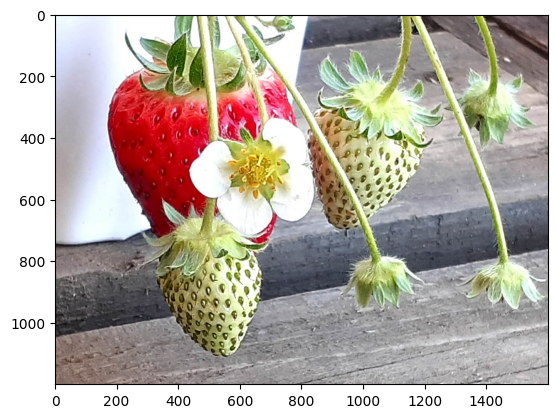

In [6]:
# 画像識別に使う画像を確認

before_img_2_addr = "../datasets/predict/predict_6.jpg"

before_img_2 = plt.imread(before_img_2_addr)
plt.imshow(before_img_2)
plt.show()

In [ ]:
# モデルを使って画像識別

model.predict(before_img_2_addr, save=True)

In [ ]:
# 識別結果を出力

after_img_2_addr = "./runs/detect/predict2/predict_6.jpg"

after_img_2 = plt.imread(after_img_2_addr)
plt.imshow(after_img_2)
plt.show()

runsを保存する

In [ ]:
# 現在日時を取得

dt_now = datetime.datetime.now()
print(dt_now)

In [ ]:
# 現在日時をもとにrunsフォルダの名前を変更

runs_add = dt_now.strftime("%m_%d_%H_%M")
os.rename("runs", f"runs_{runs_add}")

In [ ]:
# runs_{runs_add}フォルダをruns_archiveフォルダに移動

shutil.move(f"runs_{runs_add}", f"runs_archive/runs_{runs_add}")